In [65]:
import pandas as pd
import numpy as np
pd.set_option('max_columns',300)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from scipy.stats import hmean
# Data Link: http://ocslab.hksecurity.net/Datasets/driving-dataset
# maybe more data: https://www.kaggle.com/data/27093

In [35]:
obd_data = pd.read_csv('ten_drivers.csv')
obd_data = obd_data.drop(['Time(s)'], axis=1)

In [37]:
print(obd_data.shape)
obd_data.head()

(94380, 53)


,Fuel_consumption,Accelerator_Pedal_value,Throttle_position_signal,Short_Term_Fuel_Trim_Bank1,Intake_air_pressure,Filtered_Accelerator_Pedal_value,Absolute_throttle_position,Engine_soacking_time,Inhibition_of_engine_fuel_cut_off,Engine_in_fuel_cut_off,Fuel_Pressure,Long_Term_Fuel_Trim_Bank1,Engine_speed,Engine_torque_after_correction,Torque_of_friction,Flywheel_torque_(after_torque_interventions),Current_spark_timing,Engine_coolant_temperature,Engine_Idel_Target_Speed,Engine_torque,Calculated_LOAD_value,Minimum_indicated_engine_torque,Maximum_indicated_engine_torque,Flywheel_torque,Torque_scaling_factor(standardization),Standard_Torque_Ratio,Requested_spark_retard_angle_from_TCU,TCU_requests_engine_torque_limit_(ETL),TCU_requested_engine_RPM_increase,Target_engine_speed_used_in_lock-up_module,Glow_plug_control_request,Activation_of_Air_compressor,Torque_converter_speed,Current_Gear,Engine_coolant_temperature.1,Wheel_velocity_front_left-hand,Wheel_velocity_rear_right-hand,Wheel_velocity_front_right-hand,Wheel_velocity_rear_left-hand,Torque_converter_turbine_speed_-_Unfiltered,Clutch_operation_acknowledge,Converter_clutch,Gear_Selection,Vehicle_speed,Acceleration_speed_-_Longitudinal,Indication_of_brake_switch_ON/OFF,Master_cylinder_pressure,Calculated_road_gradient,Acceleration_speed_-_Lateral,Steering_wheel_speed,Steering_wheel_angle,Class,PathOrder
0,268.8,0.0,5.2,0.0,33,0,13.3,3,0,0,0,-0.8,929,5.5,9.0,-5.9,-8.6,95,650,5.5,23.9,2.0,58.2,-5.9,230,1,15,508,0.0,3040,0,0,939.3,0,87,0.0,0.0,0.0,0.0,935.5,1,0,0,0,-8.5,1,325.5,0.0,-8.8,0,-3.4,A,1
1,243.2,0.0,6.1,0.0,40,0,13.7,3,0,0,0,-0.8,726,7.0,7.8,1.7,-11.3,95,670,7.0,30.6,2.0,53.9,1.8,230,1,15,508,0.0,3040,0,0,710.0,0,87,0.0,0.0,0.0,0.0,709.5,1,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6,A,1
2,217.6,0.0,5.2,0.0,41,0,13.7,3,0,0,0,-0.8,685,7.0,7.4,-3.0,-12.8,95,670,7.0,31.8,2.0,53.1,-2.8,230,1,15,508,0.0,3040,0,0,663.3,0,87,0.0,0.0,0.0,0.0,663.5,1,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6,A,1
3,204.8,0.0,4.7,0.0,38,0,13.3,3,0,0,0,-0.8,675,7.0,6.6,-1.3,-9.8,95,670,7.0,29.0,2.0,53.1,-1.2,230,1,15,508,0.0,3040,0,0,652.5,0,87,0.0,0.0,0.0,0.0,653.0,1,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6,A,1
4,217.6,0.0,5.7,0.0,40,0,13.7,3,0,0,0,-0.8,716,8.2,11.3,-15.6,-7.9,95,670,8.2,30.2,2.0,53.5,-15.9,230,1,15,508,0.0,3040,0,1,692.5,0,87,0.0,0.0,0.0,0.0,693.8,1,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.5,A,1


In [38]:
OFFSET = 648 # it's the same for all drivers
# plt.figure(figsize=(20,8))
# plt.scatter(np.arange(obd_data.shape[0]), obd_data.Engine_speed-648)
# plt.show()
# print(np.min(obd_data.Engine_speed[:50]))
obd_data.Engine_speed = obd_data.Engine_speed - OFFSET

<h1> Data preparation </h1>

In [40]:
drivers = driver0, driver1, driver2, driver3, driver4, driver5, driver6, driver7, driver8, driver9 = [obd_data.loc[np.where(obd_data.Class == class_letter)[0]].drop('Class',axis=1) for class_letter in np.unique(obd_data.Class)]
drive_times = [d.shape[0] for d in drivers]
x = [np.arange(drive_time) for drive_time in drive_times]
print("Driving seconds of each driver:", drive_times)

Driving seconds of each driver: [7240, 12864, 7500, 13244, 8436, 11012, 7492, 9880, 7808, 8904]


<h1> Driving skills feature extraction </h1>

In [116]:
def lin_interpol(x0, x1, y0, y1, x):
    return y0 + (y1-y0)/(x1-x0) * (x - x0)

In [117]:
def calc_scores(driver): # Higher values implie worse driving behaviour!
    # 1. RPM (Q3)
    q3_rpm_norm = np.percentile(driver.Engine_speed, 75) / np.max(obd_data.Engine_speed)
    
    # 2. Stering wheel speed (Q3)
    q3_steering_speed_norm = np.percentile(driver.Steering_wheel_speed, 98)/np.max(obd_data.Steering_wheel_speed) # percentage of the sample that falls below this observation
    
    # 3. Stering wheel angle (std)
    std_wheel_angle_norm = np.std(driver.Steering_wheel_angle)/100 # percentage of the sample that falls below this observation
    # Scale to new range (because it adulterated the final score results)
    x0 = 0.4762777 # min of all std_wheel_angle_norm
    x1 = 0.7427367 # max of all std_wheel_angle_norm
    y0 = 0.2222    # new min
    y1 = 0.3       # new max
    std_wheel_angle_norm_as_score = lin_interpol(x0, x1, y0, y1, std_wheel_angle_norm)
    
    # 4. Vehicle speed: (threshold)
    LIMIT = 90
    threshold_speed_bool = np.sum(driver.Vehicle_speed > LIMIT) > 10
    speed_bool_as_score  = np.round(threshold_speed_bool * 0.1 + 0.2,2)
    
    # 5. Acceleration speed - Longitudinal: (Q3)
    q3_acc_speed_long_norm_as_score = np.percentile(np.abs(driver['Acceleration_speed_-_Longitudinal']), 80)/np.max(obd_data['Acceleration_speed_-_Longitudinal'])*3 # percentage of the sample that falls below this observation

    # 6. Throttle position: (Q3)
    q3_throttle_pos_norm = np.percentile(np.abs(driver['Absolute_throttle_position']), 80)/np.max(obd_data.Absolute_throttle_position) # percentage of the sample that falls below this observation

    # 7. Fuel consumption: (Q3)
    q3_fuel_cons_norm = np.percentile(driver.Fuel_consumption/np.max(obd_data.Fuel_consumption), 80)
    
    return q3_rpm_norm, q3_steering_speed_norm, std_wheel_angle_norm_as_score, speed_bool_as_score, q3_acc_speed_long_norm_as_score, q3_throttle_pos_norm, q3_fuel_cons_norm

In [120]:
final_scores = []
for driver in drivers: 
    score_reversed = calc_scores(driver) # Higher values implie worse driving behaviour!
    scores = [1-score for score in score_reversed]
    final_score = hmean(scores) # Higher values implie better driving behaviour!
    final_scores.append(final_score)
    
final_score_better_range = lin_interpol(np.min(final_scores), np.max(final_scores), 0.5, 0.95, final_scores)
print(final_score_better_range)

[0.5        0.80815469 0.53131721 0.85817007 0.8492827  0.95
 0.85429276 0.94666535 0.80934166 0.6915216 ]


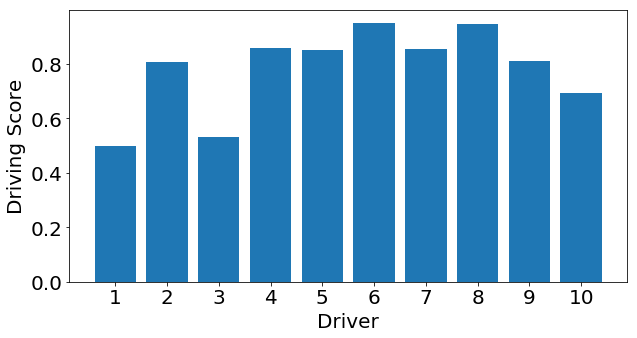

In [131]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(final_score_better_range.shape[0]), final_score_better_range, tick_label=np.arange(final_score_better_range.shape[0])+1)
plt.xlabel("Driver")
plt.ylabel("Driving Score")
plt.savefig('Final_Driving_Scores.png')
plt.show()